# MSE Time Series and Advection
This looks at how near-surface MSE develops with time throughout the year

In [1]:
import copy
import sys
import os
# REMOTE - So can access functions in isca_tools which is in home/Isca directory
# sys.path.append(os.path.join(os.environ['HOME'], 'Isca'))
# LOCAL - So can access functions in isca_tools which is in StAndrews/Isca
sys.path.append(os.environ['PWD'])
import isca_tools
from isca_tools.utils.moist_physics import moist_static_energy, clausius_clapeyron_factor, sphum_sat
from isca_tools.utils.constants import kappa, L_v, c_p
from isca_tools.utils import area_weighting, annual_mean
from isca_tools.papers.byrne_2021 import get_quant_ind
from isca_tools.thesis.aquaplanet_theory import get_delta_temp_quant_theory, get_gamma
from isca_tools.convection.simple_betts_miller import lcl_temp, ref_temp_above_lcl, get_temp_ref
from isca_tools.convection import dry_profile_pressure, moist_profile
from isca_tools.plot import label_subplots
import numpy as np
import matplotlib.pyplot as plt
import xarray as xr
import scipy.optimize
from tqdm import tqdm
from scipy import interpolate
import matplotlib.animation
from matplotlib.animation import FuncAnimation
from IPython.display import HTML
import numpy_indexed
from scipy.stats import percentileofscore
import copy
# Use custom matplotlib style for publishing
plt.style.use('/Users/joshduffield/Documents/StAndrews/Isca/jobs/tau_sweep/aquaplanet/publish_figures/publish.mplstyle')

2024-09-12 11:47:10,898 - isca - WARNING - Environment variable GFDL_SOC not set, but this is only required if using SocratesCodebase. Setting to None


In [2]:
# Load dataset - one at surface and one in free troposphere
var_keep = ['temp', 'sphum', 'height', 'precipitation', 'omega', 'ucomp', 'vcomp', 'convflag', 'klzbs']  
# Load dataset
tau_lw_ref = 1
exp_dir = 'tau_sweep/aquaplanet/depth=1/'
# exp_dir = 'tau_sweep/land/meridional_band/depth=1/bucket_evap/'
exp_name = f"k={str(tau_lw_ref).replace('.','_')}"

# exp_dir = 'rossbypalooza/variable_evap_flux/evap=0/'
# exp_name=''

use_time_start = 360*2
ds_use = isca_tools.load_dataset(exp_dir + exp_name)
try:
    ds_use = ds_use[var_keep]
except KeyError:
    remove_keys = []
    for key in var_keep:
        if key not in ds_use:
            print(f'Removing {key} from var_keep')
            remove_keys += [key]
    for key in remove_keys:
        var_keep.remove(key)
    ds_use = ds_use[var_keep]
ds_base = ds_use.sel(time=slice(use_time_start, np.inf))      # only keep after spin up
namelist = isca_tools.load_namelist(exp_dir + exp_name)  # Need this for albedo_value
albedo = namelist['mixed_layer_nml']['albedo_value']
tau_sw = namelist['two_stream_gray_rad_nml']['atm_abs']
tau_lw = namelist['two_stream_gray_rad_nml']['odp']

In [3]:
# If true, will save all figures to desktop - option to save specific figures later on.
save_fig = False
# if publishing figure, use high dpi
publish_fig = True

ar = 4/3        # aspect ratio (width/height)
# Details required for Journal of Climate Figures
low_dpi = 100
dpi = {'monochrome': 1100, 'combination': 800, 'halftone': 300}
width = {'one_col': 3.2, 'two_col': 5.5}        # width in inches 
save_pad_inches = 0.05

# Default parameters
default_colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
ax_linewidth = plt.rcParams['axes.linewidth']

## Get annual mean dataset

In [30]:
p_surf_approx = 1000
p_ft_approx = 500

region = 'tropics'
lat_min = -20
lat_max = 20
lat_use_ind = np.where((ds_base.lat <= lat_max) & (ds_base.lat >= lat_min))[0]      # just NH to save memory

lzb_thresh = 12     # Need klzb to be lower than this so LZB is less than 560hPa (14) or 413hPa (12)
convflag_thresh = 1      # Need more than this to be considered shallow convection
var_keep_annual_mean = ['temp', 'precipitation', 'omega', 'ucomp', 'vcomp', 'is_convect', 'mse', 'epsilon']

ind_surf = 0
ind_ft = 1
n_pressure = 2
ds_annual_mean = ds_base.sel(pfull=[p_surf_approx, p_ft_approx], method='nearest').isel(lat=lat_use_ind)
ds_annual_mean['is_convect'] = np.logical_and(ds_annual_mean.klzbs<=lzb_thresh, ds_annual_mean.convflag > convflag_thresh)
mse = moist_static_energy(ds_annual_mean.temp, ds_annual_mean.sphum, ds_annual_mean.height)
mse[:, ind_ft] = moist_static_energy(ds_annual_mean.temp[:, ind_ft], sphum_sat(ds_annual_mean.temp[:, ind_ft], ds_annual_mean.pfull[ind_ft]*100), 
                                ds_annual_mean.height[:, ind_ft])
ds_annual_mean['mse'] = mse
ds_annual_mean['epsilon'] = mse[:, 0] - mse[:, 1]
ds_annual_mean = annual_mean(ds_annual_mean[var_keep_annual_mean]).mean(dim='lon').load()

<xarray.Dataset>
Dimensions:        (time: 360, pfull: 2, lat: 14)
Coordinates:
  * lat            (lat) float64 -18.14 -15.35 -12.56 ... 12.56 15.35 18.14
  * pfull          (pfull) float64 994.9 486.9
  * time           (time) float64 0.5 1.5 2.5 3.5 ... 356.5 357.5 358.5 359.5
Data variables:
    temp           (time, pfull, lat) float32 298.1 297.5 297.1 ... 260.3 260.6
    precipitation  (time, lat) float32 0.0001404 0.000222 ... 1.072e-05
    omega          (time, pfull, lat) float32 -0.009353 -0.008168 ... 0.03865
    ucomp          (time, pfull, lat) float32 18.56 15.44 10.34 ... 8.513 15.23
    vcomp          (time, pfull, lat) float32 -5.302 -6.132 ... 1.256 0.6832
    is_convect     (time, lat) float64 0.03281 0.1328 0.45 ... 0.0 0.0 0.0
    mse            (time, pfull, lat) float32 334.7 331.5 329.0 ... 325.2 325.3
    epsilon        (time, lat) float32 0.04759 0.8659 1.223 ... -20.01 -25.33

## Time Evolution of Annual Mean MSE
Below we see that in NH, from January until May the meridional velocity is northward at the free troposphere bringing more energetic air from closer to the equator, and so the FT MSE reaches a peak before the surface MSE.

Then between May and October, meridional velocity is northward at the surface and southward at the surface. So convection acts to maintain $h_s=h_{FT}^*$ but southward advection acts to decrease $h_{FT}^*$ and northward advection acts to increase $h_s$. This means that $\epsilon = h_s - h_{FT}^*$ is positive. 

At the second maxima of MSE, $h_s$ peaks before $h_{FT}^*$ due to this advection effect.

In the top plot, blue dots represent convective days and the blue lines indicate the precipitation.

Text(0, 0.5, 'MSE [kJ/kg]')

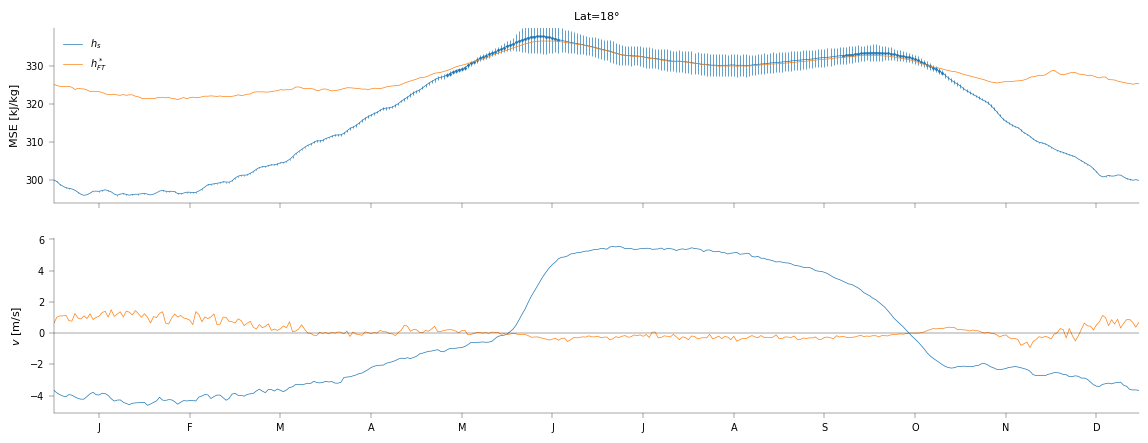

In [161]:
time_annual_mean = ds_annual_mean.time-0.5
month_ticks = (np.arange(15,12*30+15,30), ['J','F','M','A','M','J','J','A','S','O','N','D'])
plot_lat_ind = -1
is_convect_thresh = 0.25     # indicate times where greater fraction of days than this are convecting
precip_marker_size_func = lambda x: (x*40000)**3        # how to relate precipitation to marker size

fig, ax = plt.subplots(2, 1, figsize=(14,5), sharex=True)
for i in range(n_pressure):
    ax[0].plot(time_annual_mean, ds_annual_mean.mse[:, i, plot_lat_ind], color=default_colors[i], label='$h_s$' if i==0 else '$h_{FT}^*$')
    ax[1].plot(time_annual_mean, ds_annual_mean.vcomp[:, i, plot_lat_ind], color=default_colors[i])
ax[0].scatter(time_annual_mean.where(ds_annual_mean.is_convect[:, plot_lat_ind]>is_convect_thresh), 
              ds_annual_mean.mse[:, 0, plot_lat_ind].where(ds_annual_mean.is_convect[:, plot_lat_ind]>is_convect_thresh), s=1)
ax[0].scatter(time_annual_mean, ds_annual_mean.mse[:, 0, plot_lat_ind], 
              s=precip_marker_size_func(ds_annual_mean.precipitation[:, plot_lat_ind]), color=default_colors[0], marker='|')
ax[0].legend()
ax[0].set_xlim(time_annual_mean[0], time_annual_mean[-1])
ax[1].axhline(0, color='k', lw=ax_linewidth)
ax[1].set_xticks(*month_ticks)
ax[1].set_ylabel('$v$ [m/s]')
ax[0].set_title(f'Lat={int(ds_annual_mean.lat[plot_lat_ind])}$\degree$')
ax[0].set_ylabel('MSE [kJ/kg]')

### Relation between $\epsilon$ and $v$
Below we see that for non-convecting days, there is a linear increase in $\epsilon$ with $v_s - v_{FT}$ indicating that advection is the dominant process in setting the MSE.

For convecting days, $\epsilon$ stays roughly constant because while advection would act to increase $\epsilon$ as $v_s-v_{FT}$ increases, convection acts to maintain $\epsilon=0$, so we see a competition with these two effects.

Text(0.5, 1.0, 'Lat=18$\\degree$')

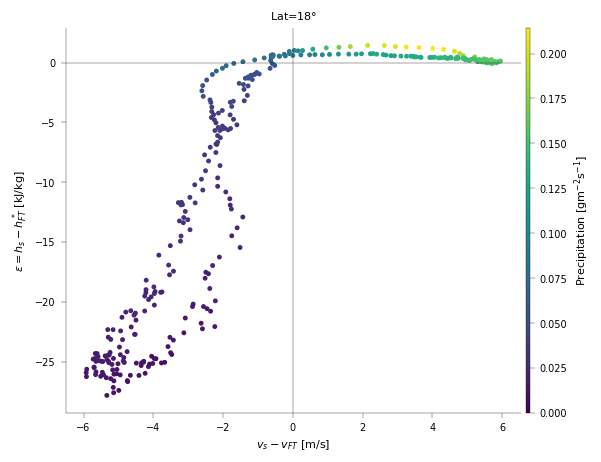

In [167]:
scatter_color_var = 'precipitation'
fig, ax = plt.subplots(1, 1, figsize=(6, 5), sharex=True, sharey=True)
im = ax.scatter((ds_annual_mean.vcomp[:, 0] - ds_annual_mean.vcomp[:, 1]).isel(lat=plot_lat_ind),
            ds_annual_mean.epsilon.isel(lat=plot_lat_ind), 
            c=ds_annual_mean[scatter_color_var].isel(lat=plot_lat_ind)*(100 if 'conv' in scatter_color_var else 1000), 
                vmin=0, vmax=100 if 'conv' in scatter_color_var else None)
plt.colorbar(im, ax=ax, aspect=100, pad=0.01, fraction=0.01, label='Percentage of days Convecting [%]' if 'conv' in scatter_color_var else 'Precipitation [gm$^{-2}$s$^{-1}$]')
ax.axhline(0, color='k', lw=ax_linewidth)
ax.axvline(0, color='k', lw=ax_linewidth)
ax.set_xlabel('$v_s - v_{FT}$ [m/s]')
ax.set_ylabel('$\epsilon = h_s - h_{FT}^*$ [kJ/kg]')
ax.set_title(f'Lat={int(ds_annual_mean.lat[plot_lat_ind])}$\degree$')